In [1]:
import numpy as np
import pandas as pd
from glob import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

In [2]:
PATH_INPUT = "../input/vinbigdata-chest-xray-abnormalities-detection/"
df_labels=pd.read_csv(PATH_INPUT+"train.csv")
df_labels["path"]=df_labels.image_id.apply(lambda x: PATH_INPUT+f"train/{x}.dicom")
df_labels.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,path
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,../input/vinbigdata-chest-xray-abnormalities-d...
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,../input/vinbigdata-chest-xray-abnormalities-d...
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,../input/vinbigdata-chest-xray-abnormalities-d...
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,../input/vinbigdata-chest-xray-abnormalities-d...
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,../input/vinbigdata-chest-xray-abnormalities-d...


In [3]:
# Change class_id values
df_labels.class_id=df_labels.class_id+1
df_labels.loc[df_labels.class_id==15,"class_id"]=0

In [4]:
df_labels.class_name.value_counts()

No finding            31818
Aortic enlargement     7162
Cardiomegaly           5427
Pleural thickening     4842
Pulmonary fibrosis     4655
Nodule/Mass            2580
Lung Opacity           2483
Pleural effusion       2476
Other lesion           2203
Infiltration           1247
ILD                    1000
Calcification           960
Consolidation           556
Atelectasis             279
Pneumothorax            226
Name: class_name, dtype: int64

In [5]:
df_labels.image_id.nunique()

15000

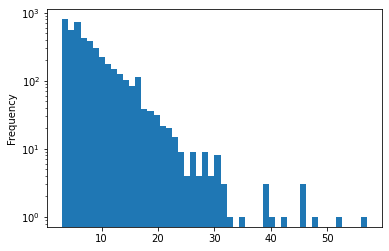

In [6]:
# Number of regions per image
df_labels.query("class_id!=0").image_id.value_counts().plot.hist(bins=50,log=True)

In [7]:
# Colormap
labels_info=df_labels.query("class_id!=0")[["class_id","class_name"]].drop_duplicates().sort_values(by="class_id").reset_index(drop=True)
labels_info["color"]=sns.color_palette("husl", labels_info.shape[0])
labels_info["color"]=labels_info["color"].apply(lambda x: tuple([int(cl*255) for cl in x]))
labels_info=labels_info.set_index("class_id",drop=True)
labels_info

,class_name,color
class_id,,
1,Aortic enlargement,"(246, 112, 136)"
2,Atelectasis,"(239, 124, 50)"
3,Calcification,"(197, 147, 49)"
4,Cardiomegaly,"(167, 158, 49)"
5,Consolidation,"(130, 168, 49)"
6,ILD,"(49, 178, 77)"
7,Infiltration,"(52, 175, 137)"
8,Lung Opacity,"(53, 172, 164)"
9,Nodule/Mass,"(55, 170, 186)"


In [8]:
## Reading a dicom file
# From: https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from skimage import exposure
import cv2

def dicom2array(path, voi_lut=True, fix_monochrome=True, equalize_hist=False, clahe_normalization=False):
    dicom = pydicom.read_file(path)
    # VOI LUT (if available by DICOM device) is used to
    # transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
        
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    
    # From: https://www.kaggle.com/raddar/popular-x-ray-image-normalization-techniques
    if equalize_hist:
        data = exposure.equalize_hist(data)
        
    if clahe_normalization:
        data = exposure.equalize_adapthist(data/np.max(data))
        
    return data

def plot_img(img, size=(7, 7), is_rgb=True, title="", cmap='gray'):
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()
    
def plot_img_with_labels(image_id,df_labels, labels_info, size=(7, 7), is_rgb=True, title="", cmap='gray'):
    df_plot = df_labels.query(f"image_id=='{image_id}'")
    img=dicom2array(df_plot.iloc[0].path)
    
    # To rgb:
    img=cv2.merge((img, img, img))
    # Draw boxes if present
    df_boxes = df_plot.query("class_id!=0")
    if df_boxes.shape[0]>0:
        for i,row in df_boxes.iterrows(): #x_min	y_min	x_max	y_max
            img = cv2.rectangle(img,(int(row.x_min), int(row.y_min)),(int(row.x_max), int(row.y_max)), labels_info.loc[row.class_id]["color"],5)
            
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()

In [9]:
df_labels.query("image_id=='9a5094b2563a1ef3ff50dc5c7ff71345'")

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,path
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,4,R10,691.0,1375.0,1653.0,1831.0,../input/vinbigdata-chest-xray-abnormalities-d...
5517,9a5094b2563a1ef3ff50dc5c7ff71345,Pleural effusion,11,R9,1789.0,1729.0,1875.0,1992.0,../input/vinbigdata-chest-xray-abnormalities-d...
25023,9a5094b2563a1ef3ff50dc5c7ff71345,Pleural thickening,12,R9,1789.0,1729.0,1875.0,1992.0,../input/vinbigdata-chest-xray-abnormalities-d...
26165,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,4,R9,692.0,1375.0,1657.0,1799.0,../input/vinbigdata-chest-xray-abnormalities-d...
42709,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,4,R8,689.0,1313.0,1666.0,1763.0,../input/vinbigdata-chest-xray-abnormalities-d...
53473,9a5094b2563a1ef3ff50dc5c7ff71345,Aortic enlargement,1,R9,1052.0,715.0,1299.0,966.0,../input/vinbigdata-chest-xray-abnormalities-d...


/opt/conda/lib/python3.7/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:177: UserWarning: The (0028,0101) 'Bits Stored' value (14-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({ds.BitsStored}-bit) "


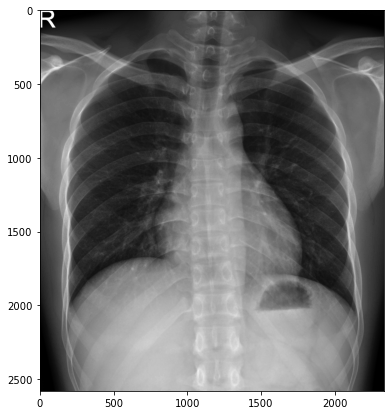

In [10]:
# No normalization
plot_img(dicom2array(df_labels.path.iloc[0]))

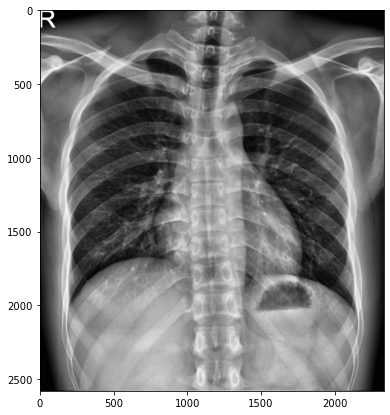

In [11]:
# Histogram normalization
plot_img(dicom2array(df_labels.path.iloc[0], clahe_normalization=True))

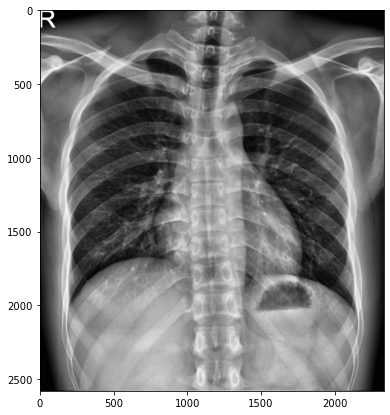

In [12]:
# CLAHE normalization
plot_img(dicom2array(df_labels.path.iloc[0], clahe_normalization=True))

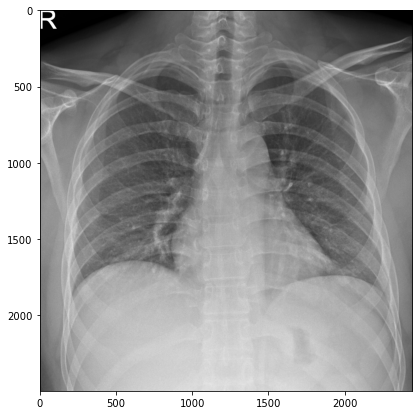

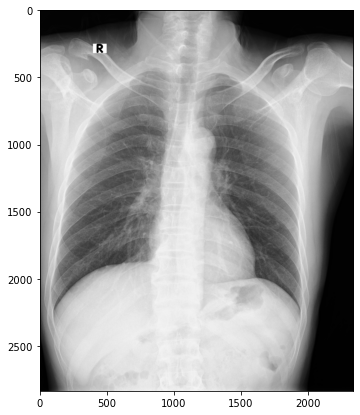

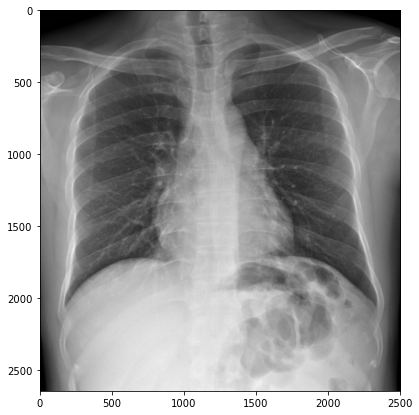

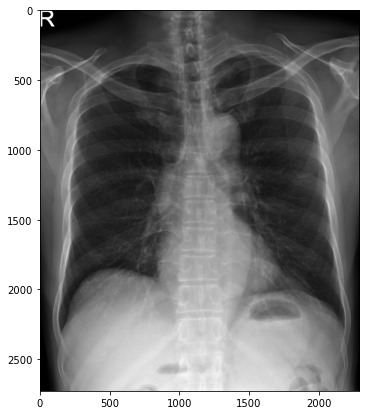

/opt/conda/lib/python3.7/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:177: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({ds.BitsStored}-bit) "


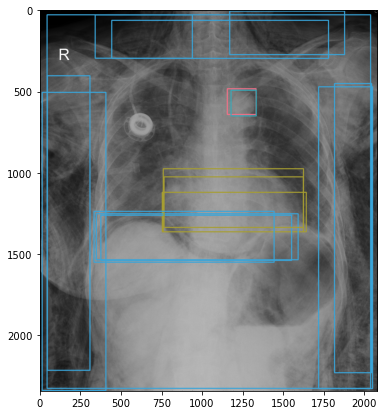

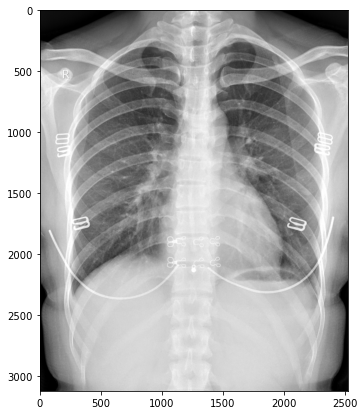

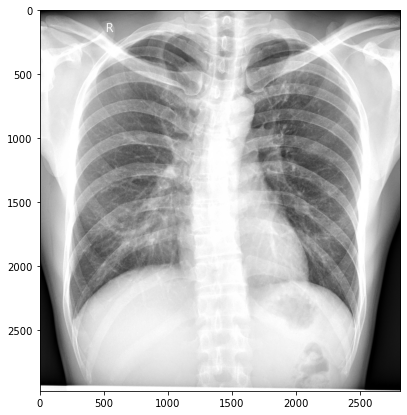

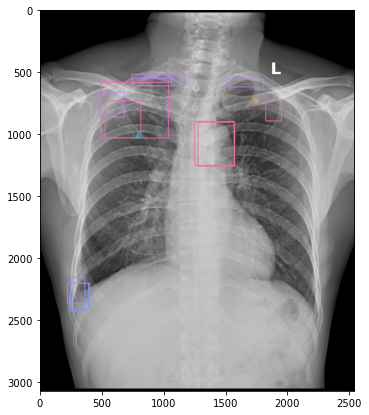

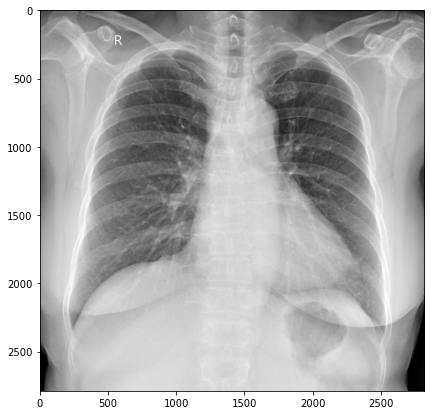

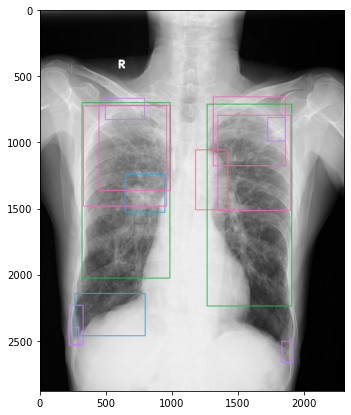

In [13]:
import random

for img_id in random.choices(df_labels.image_id.unique(),k=10):
    plot_img_with_labels(img_id,df_labels, labels_info)

In [14]:
path_example=df_labels.loc[0].path
print(path_example)
dicom2array(path_example)

../input/vinbigdata-chest-xray-abnormalities-detection/train/50a418190bc3fb1ef1633bf9678929b3.dicom


array([[255, 255, 255, ...,   1,   1,   1],
       [255, 255, 255, ...,   1,   1,   1],
       [255, 255, 255, ...,   1,   1,   1],
       ...,
       [  1,   1,   1, ...,   0,   0,   0],
       [  1,   1,   1, ...,   0,   0,   0],
       [  1,   1,   1, ...,   0,   0,   0]], dtype=uint8)

In [15]:
# Generate images in png format
imgs_to_process=df_labels.image_id.unique()

input_paths = [f"../input/vinbigdata-chest-xray-abnormalities-detection/train/{x}.dicom" for x in imgs_to_process] 
os.mkdir("./preprocessed/")
output_paths= [f"./preprocessed/{x}.png" for x in imgs_to_process]


#for inp,out in tqdm(zip(input_paths,output_paths)):
    

In [16]:
# Train / test split
# As a first approach, lets use train and test split (using test also for validation)
# TODO: Use Train / Validation / Test or kFold

df_labels.head()


random.seed(10)
random.shuffle(imgs_to_process)

perc=0.8
train_ids, test_ids=imgs_to_process[:int(len(imgs_to_process)*perc)],imgs_to_process[int(len(imgs_to_process)*perc):]

df_labels["split"]="test"
df_labels.loc[df_labels.image_id.isin(train_ids),"split"]="train"

df_train, df_test = df_labels.query("split=='train'"),df_labels.query("split=='test'")

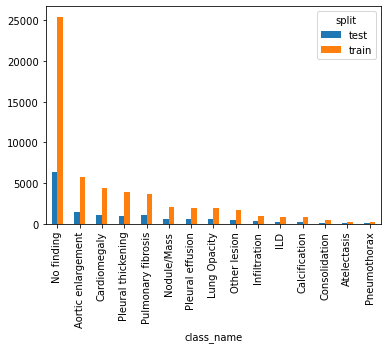

In [17]:
df_labels.groupby(["split"]).class_name.value_counts().unstack().T.sort_values(by="train",ascending=False).plot.bar()

In [18]:
df_train.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,path,split
0,50a418190bc3fb1ef1633bf9678929b3,No finding,0,R11,NaN,NaN,NaN,NaN,../input/vinbigdata-chest-xray-abnormalities-d...,train
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,0,R7,NaN,NaN,NaN,NaN,../input/vinbigdata-chest-xray-abnormalities-d...,train
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,4,R10,691.0,1375.0,1653.0,1831.0,../input/vinbigdata-chest-xray-abnormalities-d...,train
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,1,R10,1264.0,743.0,1611.0,1019.0,../input/vinbigdata-chest-xray-abnormalities-d...,train
4,063319de25ce7edb9b1c6b8881290140,No finding,0,R10,NaN,NaN,NaN,NaN,../input/vinbigdata-chest-xray-abnormalities-d...,train


In [19]:
df_test.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,path,split
9,afb6230703512afc370f236e8fe98806,Pulmonary fibrosis,14,R9,1857.0,1607.0,2126.0,2036.0,../input/vinbigdata-chest-xray-abnormalities-d...,test
12,5550a493b1c4554da469a072fdfab974,No finding,0,R9,NaN,NaN,NaN,NaN,../input/vinbigdata-chest-xray-abnormalities-d...,test
18,5da264775732004f1b724b660138854a,Aortic enlargement,1,R9,1635.0,673.0,1978.0,1151.0,../input/vinbigdata-chest-xray-abnormalities-d...,test
40,8e063eadea9a6aeb684c893c8598be3e,Nodule/Mass,9,R10,376.0,1867.0,438.0,1914.0,../input/vinbigdata-chest-xray-abnormalities-d...,test
46,d86c7405606f965ab7300ef1eacbcacc,No finding,0,R4,NaN,NaN,NaN,NaN,../input/vinbigdata-chest-xray-abnormalities-d...,test


In [20]:
%%bash
git clone https://github.com/ahmedfgad/Mask-RCNN-TF2.git
mv -f Mask-RCNN-TF2/* .
rm -rf Mask-RCNN-TF2

Cloning into 'Mask-RCNN-TF2'...


In [21]:
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

ROOT_DIR="./"
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


In [22]:
class XrayConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    NAME = "xray"
    BACKBONE = "resnet101" # "resnet50"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    NUM_CLASSES = 1 + df_labels.shape[0]  # background + labels

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = int(df_train.shape[0]/IMAGES_PER_GPU)

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = int(df_test.shape[0]/IMAGES_PER_GPU)
    
config = XrayConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                67927
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

In [28]:
# Functions to format the data for the MaskRCNN model: https://www.kaggle.com/frlemarchand/maskrcnn-for-chest-x-ray-anomaly-detection

def get_mask(img_dimensions, x_min, y_min, x_max, y_max):
    """ Return mask format for RCNN
    Given a x_min, y_min, x_max, y_max segmentation (object detection type) returns a mask
    """
    img_height, img_width = img_dimensions
    img_mask = np.full((img_height,img_width),0) # Initialize the an image with same size as original image with zeros
    img_mask[y_min:y_max,x_min:x_max] = 255 # Fill the object area with 255 values
    
    return img_mask.astype(np.float32)


def rle_encoding(x):
    dots = np.where(x.T.flatten() == 255)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join([str(x) for x in run_lengths])


def get_image_labels(df,dicom_folder, resized_folder, image_size=512):
    diagnostic_per_image = []

    for image_id in tqdm(df.image_id.unique()):
        #image_id = row.image_id
        image_df = df.query(f"image_id=='{image_id}'").query("class_id!=0") # Select all rows for an image id
        class_list = []
        RLE_list = []
        
        # Load image
        dicom_image = dicom2array(dicom_folder+image_id+".dicom", clahe_normalization=True)
        image_dimensions = dicom_image.shape
        
        # Resize and save image
        resized_img = cv2.resize(dicom_image, (image_size,image_size), interpolation = cv2.INTER_AREA)
        cv2.imwrite(resized_folder+image_id+".jpg", resized_img) 
        
        if image_df.shape[0]==0: # No annotations in the image
            class_list.append(0)
            mask = np.full(image_dimensions,0).astype(np.float32)
            resized_mask = cv2.resize(mask, (image_size,image_size))
            RLE_list.append(rle_encoding(resized_mask))
            
        else:
            for diagnostic_id, diagnostic in image_df.iterrows(): # For each annotation...
                class_list.append(diagnostic.class_id)

                mask = get_mask(image_dimensions, int(diagnostic.x_min), int(diagnostic.y_min), int(diagnostic.x_max), int(diagnostic.y_max))
                resized_mask = cv2.resize(mask, (image_size,image_size))
                RLE_list.append(rle_encoding(resized_mask))
                
        diagnostic_per_image.append({"image_id":image_id,
                                     "CategoryId":class_list,
                                     "EncodedPixels":RLE_list})
        
    samples_df = pd.DataFrame(diagnostic_per_image)
    samples_df["Height"] = image_size
    samples_df["Width"] = image_size
    return samples_df

In [ ]:
def mkdir(path):
    if not os.path.exists(path):
        os.makedirs(path)
        
mkdir("./resized/")

df_train_info= get_image_labels(df_train, 
                                 dicom_folder="../input/vinbigdata-chest-xray-abnormalities-detection/train/",
                                 resized_folder="./resized/")
df_train_info.to_csv("df_train_info.csv",index=False)

/opt/conda/lib/python3.7/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:177: UserWarning: The (0028,0101) 'Bits Stored' value (14-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({ds.BitsStored}-bit) "
/opt/conda/lib/python3.7/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:177: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({ds.BitsStored}-bit) "


In [ ]:

df_test_info= get_image_labels(df_test, 
                                 dicom_folder="../input/vinbigdata-chest-xray-abnormalities-detection/train/",
                                 resized_folder="./resized/")
df_test_info.to_csv("df_test_info.csv",index=False)

In [ ]:
# Define the dataset for MaskRCNN model

class ShapesDataset(utils.Dataset):
    """Xray Images dataset for VinBigData project.
    """

    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "square")
        self.add_class("shapes", 2, "circle")
        self.add_class("shapes", 3, "triangle")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            bg_color, shapes = self.random_image(height, width)
            self.add_image("shapes", image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, shapes=shapes)

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        image = image * bg_color.astype(np.uint8)
        for shape, color, dims in info['shapes']:
            image = self.draw_shape(image, shape, dims, color)
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        shapes = info['shapes']
        count = len(shapes)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (shape, _, dims) in enumerate(info['shapes']):
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, dims, 1)
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        return mask.astype(np.bool), class_ids.astype(np.int32)

    def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, s = dims
        if shape == 'square':
            cv2.rectangle(image, (x-s, y-s), (x+s, y+s), color, -1)
        elif shape == "circle":
            cv2.circle(image, (x, y), s, color, -1)
        elif shape == "triangle":
            points = np.array([[(x, y-s),
                                (x-s/math.sin(math.radians(60)), y+s),
                                (x+s/math.sin(math.radians(60)), y+s),
                                ]], dtype=np.int32)
            cv2.fillPoly(image, points, color)
        return image

    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        shape = random.choice(["square", "circle", "triangle"])
        # Color
        color = tuple([random.randint(0, 255) for _ in range(3)])
        # Center x, y
        buffer = 20
        y = random.randint(buffer, height - buffer - 1)
        x = random.randint(buffer, width - buffer - 1)
        # Size
        s = random.randint(buffer, height//4)
        return shape, color, (x, y, s)

    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        N = random.randint(1, 4)
        for _ in range(N):
            shape, color, dims = self.random_shape(height, width)
            shapes.append((shape, color, dims))
            x, y, s = dims
            boxes.append([y-s, x-s, y+s, x+s])
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes